In [2]:

import pandas as pd
import numpy as np
import tensorflow as tf
import os
from pathlib import Path
from utility import CoxPHLoss
from sklearn.preprocessing import StandardScaler
from data_loader import load_veterans_ds, load_cancer_ds, load_aids_ds, load_nhanes_ds # datasets
from data_loader import prepare_veterans_ds, prepare_cancer_ds, \
                        prepare_aids_ds, prepare_nhanes_ds # prepare funcs
from sksurv.linear_model.coxph import BreslowEstimator
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from model_builder import make_baseline_model

# Load data
X_train, X_valid, X_test, y_train, y_valid, y_test = load_veterans_ds()
t_train, t_valid, t_test, e_train, e_valid, e_test  = prepare_veterans_ds(y_train, y_valid, y_test)

# Scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

# Create model instance
model = make_baseline_model(input_shape=X_train.shape[1:], output_dim=1)

# Restore the weights
curr_dir = os.getcwd()
root_dir = Path(curr_dir).absolute().parent
model.load_weights(f'{root_dir}/models/baseline/')

# Compile model
optimizer = tf.keras.optimizers.Adam()
loss_fn = CoxPHLoss()
model.compile(loss=loss_fn, optimizer=optimizer)

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


In [3]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense (Dense)               (None, 20)                180       
                                                                 
 dense_1 (Dense)             (None, 50)                1050      
                                                                 
 dense_2 (Dense)             (None, 20)                1020      
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,271
Trainable params: 2,271
Non-trainable params: 0
_________________________________________________________________


In [42]:
# Train the Brewslow estimator
train_predictions = model.predict(X_train, verbose=0).reshape(-1)
breslow = BreslowEstimator().fit(train_predictions, e_train, t_train)

# Make 5 predictions
test_sample = train_test_split(X_test, y_test, e_test, t_test,
                               test_size=5, stratify=e_test, random_state=0)
x_sample, y_sample, event_sample, time_sample = test_sample[1::2]
test_predictions = model.predict(x_sample, verbose=0).reshape(-1)
test_surv_fn = breslow.get_survival_function(test_predictions)
test_hazard_fn = breslow.get_cumulative_hazard_function(test_predictions)

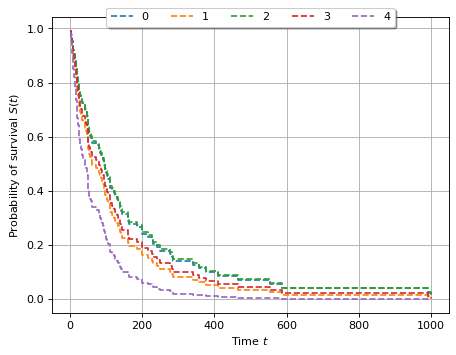

In [43]:
# Plot surv funcs
styles = ('-', '--')
plt.figure(dpi=80)
for i, (surv_fn, lbl) in enumerate(zip(test_surv_fn, event_sample)):
    plt.step(surv_fn.x, surv_fn.y, where="post", label=str(i),
             linestyle=styles[int(lbl)])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True)
plt.ylabel("Probability of survival $S(t)$")
plt.xlabel("Time $t$")
plt.grid(True)
plt.show()

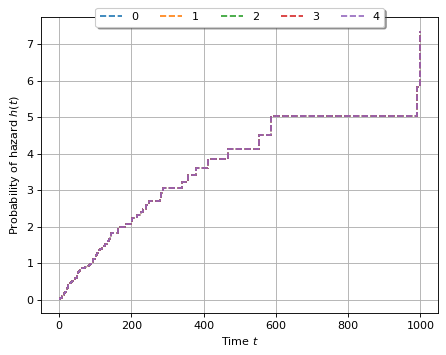

In [44]:
# Plot hazard funcs
styles = ('-', '--')
plt.figure(dpi=80)
for i, (hazard_fn, lbl) in enumerate(zip(test_hazard_fn, event_sample)):
    plt.step(hazard_fn.x, hazard_fn.y, where="post", label=str(i),
             linestyle=styles[int(lbl)])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=5, fancybox=True, shadow=True)
plt.ylabel("Probability of hazard $h(t)$")
plt.xlabel("Time $t$")
plt.grid(True)
plt.show()